# Лабораторная работа 1 

## Постановка задачи

- Сбор данных из двух разных источников (открытый датасет / веб-скрейпинг или API).
- Агрегация в единый датасет.
- Разведывательный анализ данных (EDA).
- Базовые визуализации для основных признаков с учетом разметки данных.
- Возможные применения этих данных в контексте машинного обучения.

## Описание датасета

**Идея:**

Получить данные о продуктах и ценах на них в разных магазинах, для возможности поиска наиболее выгодных предложений.
Также предполагается извлечение дополнительных признаков из описания товаров и поддержка гибкого добавления новых источников (магазинов).

**Реализация:** 

Производится веб-скрейпинг данных с сайтов https://magnit.ru/ (Магнит) и https://5ka.ru/ (Пятерочка). В данной работе производится сбор данных о ценах на товары категории "Сыр", за продолжительное время (в идеале, за каждый день).

**Применение для машинного обучения:**

Предсказание цены и размера скидки на товар как для временного ряда.

**Алгоритм обработки:**

Объект класса ProductScraper в зависимости от переданного класса магазина, посылает запросы на сайт с помощью Selenium, парсит результаты через BautifulSoup по найденным в коде страницы идентификаторам для поиска нужных элементов.
Данные считываются постранично с проверкой существования в csv такого же товара за эту же дату.
С сайтов получаем информацию: название товара, цена, скидка, рейтинг. (возможно дальнейшее добавление)

Считанная (новая) информация с текущей датой дозаписывается в csv с названием обрабатываемого магазина.

В дальнейшем производится извлечение дополнительных признаков из поля `name`:
- бренд
- вес и единица измерения
- в нарезке (да/нет)
- БЗМЖ (да/нет)

Далее данные с извлеченными фичами записываются в БД. Обработка пропусков планируется в ЛР 2.

**Замечания:**

Скрейпинг магазинов потребовал дополнительных шагов: для Пятерочки это отправка предварительного запроса на авторизацию, для Магнита - отправка cookies с адресом магазина.

## Импорт библиотек

In [1051]:
!pip install -q selenium psycopg2 matplotlib seaborn polars

In [1052]:
from sqlalchemy import create_engine, Column, Float, String, Date, Boolean, Integer
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from typing import Optional, Tuple, Dict

from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from rapidfuzz import fuzz
from datetime import date
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
import requests
import random
import time
import csv
import os
import re

## Конфигурация подключения к базе данных

In [451]:
Base = declarative_base()

DATABASE_URL = "postgresql+psycopg2://{username}:{password}@{host}:{port}/{db_name}".format(
    host=os.getenv("POSTGRES_HOST", "localhost"),
    port=os.getenv("POSTGRES_PORT", "5432"),
    db_name=os.getenv("POSTGRES_DB", "store_parser"),
    username=os.getenv("POSTGRES_USER", "postgres"),
    password=os.getenv("POSTGRES_PASSWORD", "123456"),

)

def init_db():
    engine = create_engine(DATABASE_URL)
    Base.metadata.create_all(engine)
    Session = sessionmaker(bind=engine)
    return Session()

C:\Users\admin\AppData\Local\Temp\ipykernel_11948\988954521.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


## Класс, соответствующий структуре таблицы в БД

In [503]:
class Product(Base):
    __tablename__ = 'store_products'

    name = Column(String, nullable=False, primary_key=True)
    brand = Column(String)
    price = Column(Float)  
    weight = Column(Float)
    unit = Column(String)
    fat_content = Column(Float, nullable=True)
    is_sliced = Column(Boolean, nullable=True)
    is_bzmj = Column(Boolean, nullable=True)
    discount = Column(Float, nullable=True) 
    rating = Column(Float, nullable=True)
    date_added = Column(Date, default=date.today, primary_key=True)  
    store = Column(String, nullable=False, primary_key=True)

    __table_args__ = {'extend_existing': True}

    def __repr__(self):
        return f"<Product(name='{self.name}', price={self.price}, date_added={self.date_added}, store={self.store})>"

C:\Users\admin\AppData\Local\Temp\ipykernel_11948\547102057.py:1: SAWarning: This declarative base already contains a class with the same class name and module name as __main__.Product, and will be replaced in the string-lookup table.
  class Product(Base):


## Абстрактный класс конфигураций скрапера магазина

In [5]:
class StoreScraper(ABC):
    def __init__(self):
        self.store_name = ""
        self.base_url = ""
        self.auth_url = None
        self.product_selector = ""
        self.name_selector = ""
        self.price_selector = ""
        self.page_param = ""
        self.discount_selector = ""  
        self.rating_selector = ""  

    @abstractmethod
    def clean_price(self, price_str: str) -> float:
        pass

    @abstractmethod
    def clean_discount(self, discount_str: str) -> Optional[float]:
        pass

    @abstractmethod
    def clean_rating(self, rating_str: str) -> Optional[float]:
        pass

    def get_url(self, page: int) -> str:
        return f"{self.base_url}{self.page_param}{page}"

## Конфигурации для скрапинга Пятерочки

In [1021]:
class PyaterochkaScraper(StoreScraper):
    def __init__(self):
        super().__init__()
        self.store_name = "Пятерочка"
        self.base_url = "https://5ka.ru/catalog/syr--251C13095/"
        self.auth_url = "https://id.x5.ru/auth/realms/ssox5id/protocol/openid-connect/login-status-iframe.html/init?client_id=tc5_site&origin=https%3A%2F%2F5ka.ru"
        self.product_selector = lambda tag: tag.get('data-qa', '') and re.compile(r'product-card-\d+$').match(tag.get('data-qa', ''))
        self.name_selector = '.chakra-text.SdLEFc2B-.css-1jdqp4k'
        self.price_selector = '.chakra-text.DUXYWqnZ-.css-6uvdux'
        self.price_cents_selector = '.chakra-text.j2bifgeA-.css-6uvdux'
        self.discount_selector = '.chakra-text.PFxTBQyj-.css-qzip67'  
        self.rating_selector = '.chakra-text.o1tGK2uB-.css-1jdqp4k' 
        self.page_param = "?page="
        self.headers = {
            "Accept": "*/*",
            "Accept-Encoding": "gzip, deflate, br, zstd",
            "Accept-Language": "ru,en;q=0.9",
            "Cache-Control": "no-cache",
            "Connection": "keep-alive",
            "Host": "id.x5.ru",
            "Pragma": "no-cache",
            "Sec-Fetch-Dest": "empty",
            "Sec-Fetch-Mode": "cors",
            "Sec-Fetch-Site": "same-origin",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36",
            "sec-ch-ua": '"Not A(Brand";v="8", "Chromium";v="132"',
            "sec-ch-ua-mobile": "?0",
            "sec-ch-ua-platform": '"Windows"'
        }

    def clean_price(self, price_str: str, price_cents: str = "0") -> float:
        cleaned = price_str.replace(' ', '').replace('\xa0', '')
        return float(cleaned + '.' + price_cents) if cleaned else 0.0

    def clean_discount(self, discount_str: str) -> Optional[float]:
        if discount_str:
            match = re.search(r'(\d+[,.]?\d*)%', discount_str)
            if match:
                return float(match.group(1).replace(',', '.'))
        return None

    def clean_rating(self, rating_str: str) -> Optional[float]:
        if rating_str:
            match = re.search(r'(\d+[,.]?\d*)', rating_str)
            if match:
                return float(match.group(1).replace(',', '.'))
        return None

## Конфигурации скрапера Магнита

In [7]:
class MagnitScraper(StoreScraper):
    def __init__(self):
        super().__init__()
        self.store_name = "Магнит"
        self.base_url = "https://magnit.ru/catalog/37741-syry_mm?shopCode=161924&shopType=1&page="
        self.product_selector = '.unit-catalog-product-preview'
        self.name_selector = '.unit-catalog-product-preview-title'
        self.price_selector = '.unit-catalog-product-preview-prices__regular'
        self.discount_selector = '.unit-catalog-product-preview__discount'  
        self.rating_selector = '.unit-catalog-product-preview-rating-score' 
        self.page_param = ""
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
            "Content-Type": "application/x-www-form-urlencoded",
        }
        self.data = {
            "element": "CityStore",
            "block": "toolBar",
            "city": "Санкт-Петербург г",
            "store_id": "161924",
        }

    def clean_price(self, price_str: str) -> float:
        cleaned = price_str[:-1].strip().replace(',', '.')
        return float(cleaned) if cleaned else 0.0

    def clean_discount(self, discount_str: str) -> Optional[float]:
        if discount_str:
            match = re.search(r'(\d+[,.]?\d*)%', discount_str)
            if match:
                return float(match.group(1).replace(',', '.'))
        return None

    def clean_rating(self, rating_str: str) -> Optional[float]:
        if rating_str:
            match = re.search(r'(\d+[,.]?\d*)', rating_str)
            if match:
                return float(match.group(1).replace(',', '.'))
        return None

## Реализация обращения к сайтам и сбора данных

In [397]:
class ProductScraper:
    def __init__(self, store_scraper):
        self.store = store_scraper
        self.driver = self._setup_driver()
        self.csv_filename = f"{self.store.store_name}_products.csv"

    def _setup_driver(self):
        options = webdriver.ChromeOptions()
        options.add_argument("--headless")
        options.add_argument("--no-sandbox")
        options.add_argument("--disable-dev-shm-usage")
        options.add_argument(f"user-agent={self.store.headers['User-Agent']}")
        service = Service(executable_path="C:/Users/admin/Downloads/chromedriver-win64/chromedriver-win64/chromedriver.exe")
        return webdriver.Chrome(service=service, options=options)

    def _setup_magnit_store(self):
        """Настройка города и магазина для Магнита"""
        if isinstance(self.store, MagnitScraper):
            print("Настраиваем город и магазин для Магнита...")
            self.driver.get("https://magnit.ru/")
            time.sleep(2)

            # Устанавливаем cookies вручную для выбора магазина
            self.driver.add_cookie({"name": "store_id", "value": "161924"})
            self.driver.add_cookie({"name": "city", "value": "Санкт-Петербург г"})

            self.driver.refresh()
            time.sleep(1)

    def _authorize_pyaterochka(self):
        if self.store.auth_url and isinstance(self.store, PyaterochkaScraper):
            print(f"Выполняем авторизацию для Пятёрочки: {self.store.auth_url}")
            # Выполняем GET-запрос с кастомными заголовками через JavaScript
            script = """
                var xhr = new XMLHttpRequest();
                xhr.open("GET", arguments[0], true);
                var headers = arguments[1];
                for (var key in headers) {
                    xhr.setRequestHeader(key, headers[key]);
                }
                xhr.send();
            """
            self.driver.execute_script(script, self.store.auth_url, self.store.headers)
            time.sleep(3) 
            self.driver.get(self.store.auth_url)  
    
    def scrape_to_csv(self):
        file_exists = os.path.isfile(self.csv_filename)

        with open(self.csv_filename, 'a', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['name', 'price', 'discount', 'rating', 'date_added', 'store']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=';')

            if not file_exists:
                writer.writeheader()

            page = 1
            current_date = str(date.today())
            
            # Настройка для Магнита
            self._setup_magnit_store()

            # Авторизация для Пятерочки
            self._authorize_pyaterochka()
            
            seen_products = set()

            if file_exists:
                with open(self.csv_filename, 'r', encoding='utf-8') as f:
                    reader = csv.DictReader(f, delimiter=';')
                    for row in reader:
                        seen_products.add((row['name'], float(row['price']), row['date_added'], row['store']))
            
            while True:                
                url = self.store.get_url(page)
                print(f"Запрос страницы: {url}")
                self.driver.get(url)
                time.sleep(4) 

                soup = BeautifulSoup(self.driver.page_source, "html.parser")
                products = soup.find_all(self.store.product_selector) if callable(
                    self.store.product_selector) else soup.select(self.store.product_selector)

                print(f"Найдено элементов на странице: {len(products)}")
                if not products:
                    print("Товары не найдены или все страницы загружены!")
                    break

                new_products = 0
                for item in products:
                    try:
                        name_elem = item.select_one(self.store.name_selector)
                        name = name_elem.text.strip() if name_elem else None

                        price_elem = item.select_one(self.store.price_selector)
                        price_str = price_elem.text.strip() if price_elem else None

                        discount_elem = item.select_one(self.store.discount_selector)
                        discount_str = discount_elem.text.strip() if discount_elem else None
                        discount = self.store.clean_discount(discount_str) if discount_str else None

                        rating_elem = item.select_one(self.store.rating_selector)
                        rating_str = rating_elem.text.strip() if rating_elem else None
                        rating = self.store.clean_rating(rating_str) if rating_str else None

                        if isinstance(self.store, PyaterochkaScraper):
                            price_cents_elem = item.select_one(self.store.price_cents_selector)
                            price_cents = price_cents_elem.text if price_cents_elem else "0"
                            price = self.store.clean_price(price_str, price_cents) if price_str else None
                        else:
                            price = self.store.clean_price(price_str) if price_str else None

                        product_key = (name, price, current_date, self.store.store_name)

                        if product_key in seen_products or name is None or price is None:
                            continue

                        seen_products.add(product_key)
                        product_dict = {
                            "name": name,
                            "price": price,
                            "discount": discount,
                            "rating": rating,
                            "date_added": current_date,
                            "store": self.store.store_name
                        }
                        writer.writerow(product_dict)
                        new_products += 1
                        # print(f"Добавлен товар: {product_dict}")

                    except Exception as e:
                        print(f"Ошибка при парсинге товара: {e}")
                        continue

                print(f"Страница {page} загружена, новых товаров: {new_products}")
                if new_products == 0:
                    print("Новых товаров не найдено, завершаем.")
                    break

                page += 1 
                time.sleep(random.uniform(1, 3))

        self.driver.quit()
        print(f"Данные добавлены в {self.csv_filename}")

## Функции для извлечения дополнительных признаков

In [483]:
def extract_brand(name: str) -> Optional[str]:
    words = name.split()
    if len(words) < 2:
        return None

    brand_words = []
    for word in words[1:]:  # Начинаем со второго слова
        if word and word[0].isupper():
            brand_words.append(word)
        elif brand_words:
            break

    return " ".join(brand_words) if brand_words else None

def extract_weight_and_unit(name: str) -> Tuple[float, str]:
    if 'весовой' in name.lower():
        return 1.0, 'кг'
    weight_pattern = re.compile(r'(\d+[,.]?\d*)\s*(г|кг|мл|л)')
    match = weight_pattern.search(name)
    if match:
        weight = float(match.group(1).replace(',', '.'))
        return weight, match.group(2)
    return 1.0, 'кг'

def extract_fat_content(name: str) -> Optional[float]:
    fat_pattern = re.compile(r'(\d+[,.]?\d*)\s*%')
    match = fat_pattern.search(name)
    if match:
        return float(match.group(1).replace(',', '.'))
    return None

def is_sliced(name: str):
    if ("нарезка" in name.lower()):
        return True
    else: 
        return None

def is_bzmj(name: str):
    if ("бзмж" in name.lower()):
        return True
    else: 
        return None

## Преобразование данных и запись в БД

In [1096]:
csv_schema = {
    "name": pl.Utf8,
    "price": pl.Float64,
    "discount": pl.Float32,
    "rating": pl.Float32,
    "date_added": pl.Date,
    "store": pl.Utf8
}

In [1238]:
def process_csv_to_db(csv_filename: str, session) -> None:
    df = pd.read_csv(csv_filename, delimiter=';')
    
    df['date_added'] = pd.to_datetime(df['date_added']).dt.date

    # Извлекаем дополнительные признаки
    df['brand'] = df['name'].apply(extract_brand)
    df['weight'] = df['name'].apply(lambda x: extract_weight_and_unit(x)[0])
    df['unit'] = df['name'].apply(lambda x: extract_weight_and_unit(x)[1])
    df['fat_content'] = df['name'].apply(extract_fat_content)
    df['is_sliced'] = df['name'].apply(is_sliced)
    df['is_bzmj'] = df['name'].apply(is_bzmj)

    existing_products = {
        (row.name, row.date_added, row.store) 
         for row in session.query(Product.name, Product.date_added, Product.store).all()
    }
    # print(existing_products)
    count = 0
    for _, row in df.iterrows():
        product_key = (row['name'], row['date_added'], row['store'])
        # print(product_key)
        if product_key not in existing_products:
            product_db = Product(
                name=row['name'],
                price=row['price'],
                date_added=row['date_added'],
                store=row['store'],
                brand=row['brand'] if pd.notna(row['brand']) else None,
                weight=row['weight'] if pd.notna(row['weight']) else None,
                unit=row['unit'] if pd.notna(row['unit']) else None,
                fat_content=row['fat_content'] if pd.notna(row['fat_content']) else None,
                is_sliced=row['is_sliced'] if pd.notna(row['is_sliced']) else None,
                is_bzmj=row['is_bzmj'] if pd.notna(row['is_bzmj']) else None,
                discount=row['discount'] if pd.notna(row['discount']) else None,  
                rating=row['rating'] if pd.notna(row['rating']) else None 
            )
            session.add(product_db)
            count += 1
    session.commit()
    print(f"{count}  {csv_filename} обработаны и записаны в базу данных")

## Вызов скрапера Пятерочки и запись в CSV

In [1025]:
pyaterochka_scraper = PyaterochkaScraper()
scraper = ProductScraper(pyaterochka_scraper)
scraper.scrape_to_csv()

Выполняем авторизацию для Пятёрочки: https://id.x5.ru/auth/realms/ssox5id/protocol/openid-connect/login-status-iframe.html/init?client_id=tc5_site&origin=https%3A%2F%2F5ka.ru
Запрос страницы: https://5ka.ru/catalog/syr--251C13095/?page=1
Найдено элементов на странице: 12
Страница 1 загружена, новых товаров: 12
Запрос страницы: https://5ka.ru/catalog/syr--251C13095/?page=2
Найдено элементов на странице: 24
Страница 2 загружена, новых товаров: 12
Запрос страницы: https://5ka.ru/catalog/syr--251C13095/?page=3
Найдено элементов на странице: 36
Страница 3 загружена, новых товаров: 12
Запрос страницы: https://5ka.ru/catalog/syr--251C13095/?page=4
Найдено элементов на странице: 48
Страница 4 загружена, новых товаров: 12
Запрос страницы: https://5ka.ru/catalog/syr--251C13095/?page=5
Найдено элементов на странице: 60
Страница 5 загружена, новых товаров: 12
Запрос страницы: https://5ka.ru/catalog/syr--251C13095/?page=6
Найдено элементов на странице: 72
Страница 6 загружена, новых товаров: 12
Зап

## Вызов скрапера Магнита и запись в CSV

In [1017]:
magnit_scraper = MagnitScraper()
scraper = ProductScraper(magnit_scraper)
scraper.scrape_to_csv()

Настраиваем город и магазин для Магнита...
Запрос страницы: https://magnit.ru/catalog/37741-syry_mm?shopCode=161924&shopType=1&page=1
Найдено элементов на странице: 33
Страница 1 загружена, новых товаров: 33
Запрос страницы: https://magnit.ru/catalog/37741-syry_mm?shopCode=161924&shopType=1&page=2
Найдено элементов на странице: 33
Страница 2 загружена, новых товаров: 33
Запрос страницы: https://magnit.ru/catalog/37741-syry_mm?shopCode=161924&shopType=1&page=3
Найдено элементов на странице: 13
Страница 3 загружена, новых товаров: 13
Запрос страницы: https://magnit.ru/catalog/37741-syry_mm?shopCode=161924&shopType=1&page=4
Найдено элементов на странице: 0
Товары не найдены или все страницы загружены!
Данные добавлены в Магнит_products.csv


## Проверка сохраненных данных

In [1045]:
pyaterochka_df = pl.read_csv("Пятерочка_products.csv", separator=';', schema=csv_schema, try_parse_dates=True)
print("Пятерочка:", len(pyaterochka_df))
print("\nПример данных из Пятерочки (последние записи):")
pyaterochka_df.tail()

Пятерочка: 455

Пример данных из Пятерочки (последние записи):


name,price,discount,rating,date_added,store
str,f64,f32,f32,date,str
"""Сыр La Paulina Чеддер твердый …",399.99,10.0,4.81,2025-03-31,"""Пятерочка"""
"""Сыр Gruyere твердый 49% БЗМЖ""",329.9,null,4.79,2025-03-31,"""Пятерочка"""
"""Сыр Kesidis Халлуми Традиционн…",169.99,null,4.94,2025-03-31,"""Пятерочка"""
"""Сыр Laplandia Emmental полутве…",197.99,23.0,4.86,2025-03-31,"""Пятерочка"""
"""Сыр Верещагин Верещагинский Зе…",1299.0,null,null,2025-03-31,"""Пятерочка"""


In [1049]:
magnit_df = pl.read_csv("Магнит_products.csv", separator=';', schema=csv_schema, try_parse_dates=True)
print("Магнит:", len(magnit_df))
print("\nПример данных из Магнита (последние записи):")
magnit_df.tail()

Магнит: 328

Пример данных из Магнита (последние записи):


name,price,discount,rating,date_added,store
str,f64,f32,f32,date,str
"""Сыр творожный Pretto с травами…",114.99,36.0,4.8,2025-03-31,"""Магнит"""
"""Сыр плавленый Viola Cливочный …",129.99,15.0,4.7,2025-03-31,"""Магнит"""
"""Сыр Laime Пармезан выдержанный…",659.97,15.0,4.6,2025-03-31,"""Магнит"""
"""Сыр Экомилк творожный 60% 350г""",329.99,null,4.4,2025-03-31,"""Магнит"""
"""Сыр Василеостровская сыроварня…",159.99,null,null,2025-03-31,"""Магнит"""


## Инициализация БД

In [507]:
session = init_db()

## Сохранение данных Пятерочки в БД

In [1203]:
# session.rollback()

In [1205]:
process_csv_to_db("Пятерочка_products.csv", session)

116 строк из Пятерочка_products.csv обработаны и записаны в базу данных


In [1207]:
# Определение схемы данных
load_schema = {
    "name": pl.Utf8,
    "price": pl.Float64,
    "date_added": pl.Date,
    "store": pl.Utf8,
    "brand": pl.Utf8,
    "weight": pl.Float32,
    "unit": pl.Utf8,
    "fat_content": pl.Float32,
    "is_sliced": pl.Boolean,
    "is_bzmj": pl.Boolean,
    "discount": pl.Float32,
    "rating": pl.Float32
}

In [1209]:
results = (
    session.query(Product)
    .filter(Product.store == 'Пятерочка')
    .order_by(Product.date_added.asc())
    .all()
)

data_5ka = [{
    "name": product.name,
    "price": product.price,
    "date_added": product.date_added,
    "store": product.store,
    "brand": product.brand,
    "weight": product.weight,
    "unit": product.unit,
    "fat_content": product.fat_content,
    "is_sliced": product.is_sliced,
    "is_bzmj": product.is_bzmj,
    "discount": product.discount,
    "rating": product.rating
} for product in results]


df_5ka = pl.DataFrame(data_5ka, schema=load_schema)
pl.Config.set_fmt_str_lengths(100)
df_5ka.tail()

name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,discount,rating
str,f64,date,str,str,f32,str,f32,bool,bool,f32,f32
"""Сыр La Paulina Чеддер твердый 48% БЗМЖ 180г""",399.99,2025-03-31,"""Пятерочка""","""La Paulina Чеддер""",180.0,"""г""",48.0,null,true,10.0,4.81
"""Сыр Gruyere твердый 49% БЗМЖ""",329.9,2025-03-31,"""Пятерочка""","""Gruyere""",1.0,"""кг""",49.0,null,true,null,4.79
"""Сыр Kesidis Халлуми Традиционный для гриля рассольный 40% БЗМЖ 200г""",169.99,2025-03-31,"""Пятерочка""","""Kesidis Халлуми Традиционный""",200.0,"""г""",40.0,null,true,null,4.94
"""Сыр Laplandia Emmental полутвердый 45% БЗМЖ 120г""",197.99,2025-03-31,"""Пятерочка""","""Laplandia Emmental""",120.0,"""г""",45.0,null,true,23.0,4.86
"""Сыр Верещагин Верещагинский Зеленый полутвердый 50% БЗМЖ""",1299.0,2025-03-31,"""Пятерочка""","""Верещагин Верещагинский Зеленый""",1.0,"""кг""",50.0,null,true,null,null


## Сохранение данных Магнита в БД

In [1211]:
process_csv_to_db("Магнит_products.csv", session)

79 строк из Магнит_products.csv обработаны и записаны в базу данных


In [1213]:
results = (
    session
    .query(Product)
    .filter(Product.store == 'Магнит')
    .order_by(Product.date_added.asc())
    .all()
)

data_magnit = [{
    "name": product.name,
    "price": product.price,
    "date_added": product.date_added,
    "store": product.store,
    "brand": product.brand,
    "weight": product.weight,
    "unit": product.unit,
    "fat_content": product.fat_content,
    "is_sliced": product.is_sliced,
    "is_bzmj": product.is_bzmj,
    "discount": product.discount,
    "rating": product.rating
} for product in results]

# df_magnit = pd.DataFrame(data_magnit)
df_magnit = pl.DataFrame(data_magnit, schema=load_schema)

df_magnit.tail(3)

name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,discount,rating
str,f64,date,str,str,f32,str,f32,bool,bool,f32,f32
"""Сыр плавленый Карат Шоколадный 30% 230г""",159.99,2025-03-31,"""Магнит""","""Карат Шоколадный""",230.0,"""г""",30.0,null,null,15.0,4.8
"""Сыр Rokler пастообразный сливочный 45% 370г""",239.99,2025-03-31,"""Магнит""","""Rokler""",370.0,"""г""",45.0,null,null,29.0,5.0
"""Сыр Варвара-Краса Сметанковый 50% 160г""",144.99,2025-03-31,"""Магнит""","""Варвара-Краса Сметанковый""",160.0,"""г""",50.0,null,null,23.0,4.7


## Получение всех данных

In [1216]:
results = (
    session
    .query(Product)
    .order_by(Product.date_added.asc())
    .all()
)

data = [{
    "name": product.name,
    "price": product.price,
    "date_added": product.date_added,
    "store": product.store,
    "brand": product.brand,
    "weight": product.weight,
    "unit": product.unit,
    "fat_content": product.fat_content,
    "is_sliced": product.is_sliced,
    "is_bzmj": product.is_bzmj,
    "discount": product.discount,
    "rating": product.rating
} for product in results]

# df = pd.DataFrame(data)
df = pl.DataFrame(data, schema=load_schema)
df.sample(5)

name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,discount,rating
str,f64,date,str,str,f32,str,f32,bool,bool,f32,f32
"""Сыр President Камамбер мягкий с белой плесенью 45% БЗМЖ 125г""",354.99,2025-03-28,"""Пятерочка""","""President Камамбер""",125.0,"""г""",45.0,null,true,null,null
"""Сыр Сыробогатов Альпийское утро плавленый 45% 400г""",229.99,2025-03-29,"""Магнит""","""Сыробогатов Альпийское""",400.0,"""г""",45.0,null,null,25.0,4.7
"""Сыр Landkaas Гауда 45% весовой""",230.97,2025-03-26,"""Магнит""","""Landkaas Гауда""",1.0,"""кг""",45.0,null,null,null,null
"""Сыр творожный Violette сливочный 70% БЗМЖ 180г""",184.99,2025-03-26,"""Пятерочка""","""Violette""",180.0,"""г""",70.0,null,true,null,null
"""Сыр Тысяча Озер Сливочный нарезка 50% БЗМЖ 125г""",144.99,2025-03-31,"""Пятерочка""","""Тысяча Озер Сливочный""",125.0,"""г""",50.0,true,true,14.0,4.9


In [633]:
session.close()

## Исследование данных

In [1222]:
df.schema

Schema([('name', String),
        ('price', Float64),
        ('date_added', Date),
        ('store', String),
        ('brand', String),
        ('weight', Float32),
        ('unit', String),
        ('fat_content', Float32),
        ('is_sliced', Boolean),
        ('is_bzmj', Boolean),
        ('discount', Float32),
        ('rating', Float32)])

In [1224]:
df.describe()

statistic,name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,discount,rating
str,str,f64,str,str,str,f64,str,f64,f64,f64,f64,f64
"""count""","""783""",783.0,"""783""","""783""","""783""",783.0,"""783""",755.0,89.0,452.0,222.0,371.0
"""null_count""","""0""",0.0,"""0""","""0""","""0""",0.0,"""0""",28.0,694.0,331.0,561.0,412.0
"""mean""",null,196.515338,"""2025-03-28 10:47:21.379000""",null,null,170.689651,null,48.166889,1.0,1.0,19.301802,4.809057
"""std""",null,98.366849,null,null,null,103.954887,null,9.597813,null,null,7.140725,0.12441
"""min""","""Пармезан Dolce Granto 40% БЗМЖ 200г""",16.99,"""2025-03-26""","""Магнит""","""Almette""",1.0,"""г""",15.0,1.0,1.0,9.0,4.3
"""25%""",null,129.99,"""2025-03-26""",null,null,125.0,null,45.0,null,null,14.0,4.7
"""50%""",null,179.99,"""2025-03-28""",null,null,150.0,null,45.0,null,null,19.0,4.85
"""75%""",null,239.99,"""2025-03-29""",null,null,200.0,null,55.0,null,null,23.0,4.9
"""max""","""Фета Sveza нежная 45% БЗМЖ 250г""",1299.0,"""2025-03-31""","""Пятерочка""","""Экомилк Фетика""",400.0,"""кг""",80.0,1.0,1.0,37.0,5.0


## Графики распределения

### Распределение цен

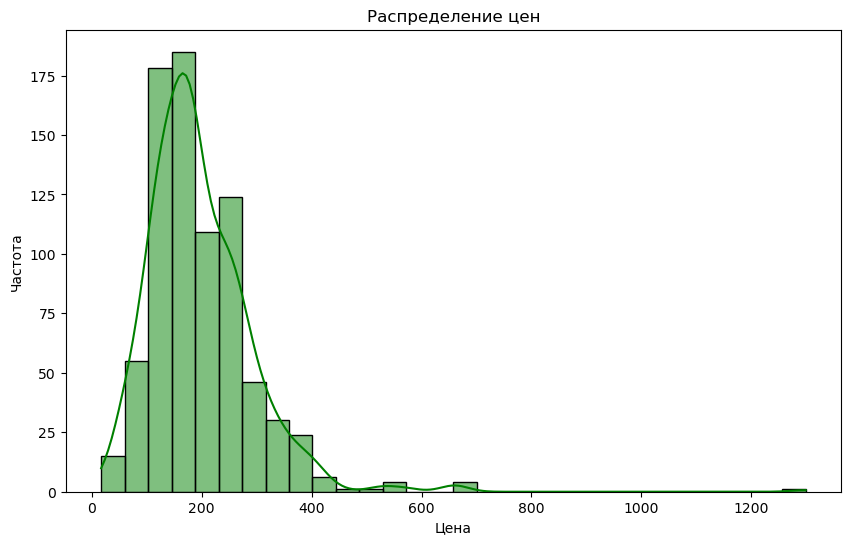

In [1242]:
# Распределение цен
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True, color='green')
plt.title('Распределение цен')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

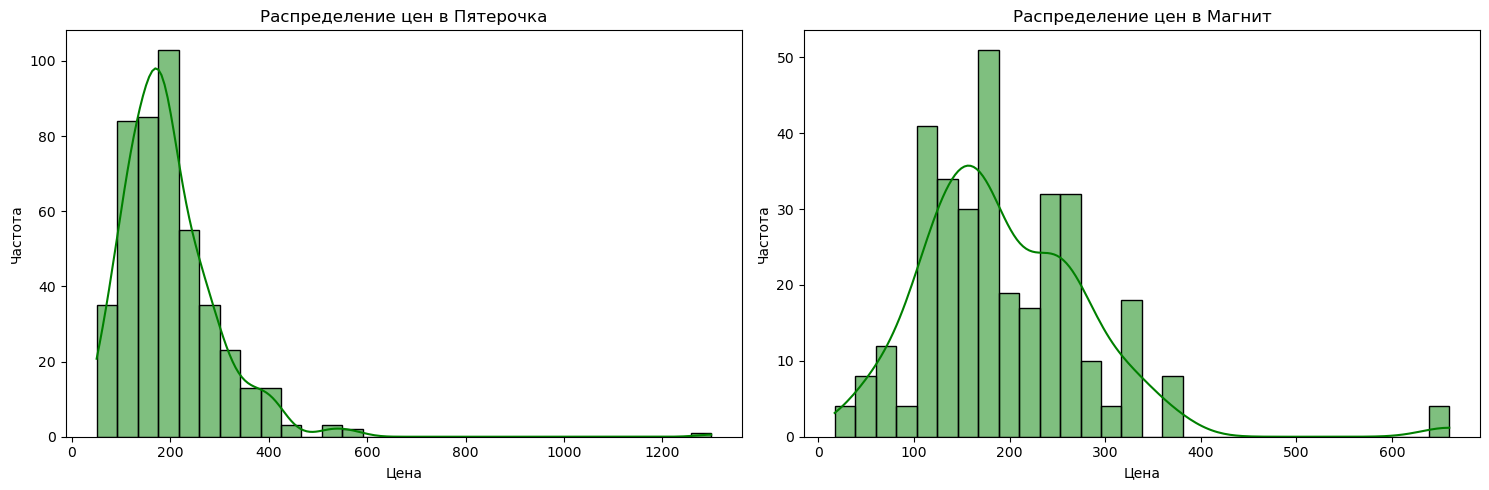

In [1250]:
# Распределение цен по магазинам
stores = df['store'].unique()
n_stores = len(stores)

n_rows = (n_stores + 1) // 2 
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() 

for i, store in enumerate(stores):
    df_store = df.filter(pl.col('store') == store)
    sns.histplot(df_store['price'], bins=30, kde=True, ax=axes[i], color='green')
    axes[i].set_title(f'Распределение цен в {store}')
    axes[i].set_xlabel('Цена')
    axes[i].set_ylabel('Частота')

for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Распределение рейтингов

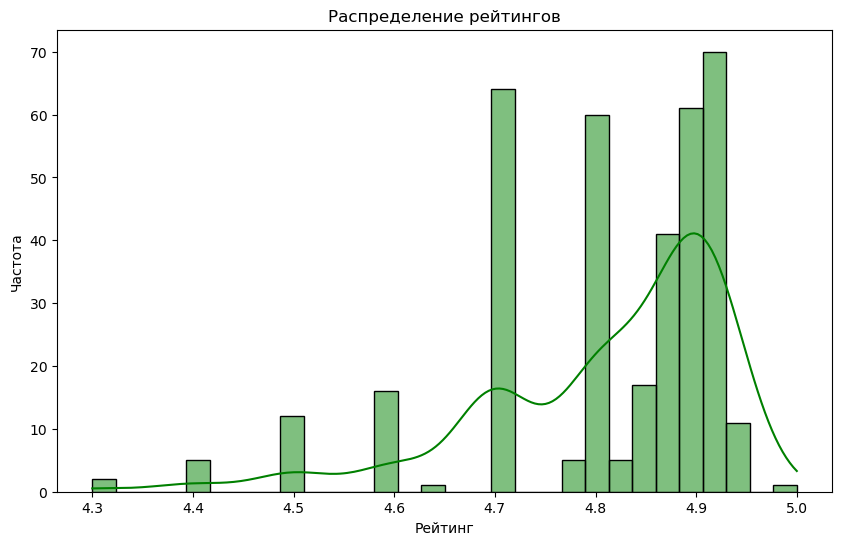

In [1252]:
# Распределение рейтингов
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=30, kde=True, color='green')
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.show()

### Распределение скидок

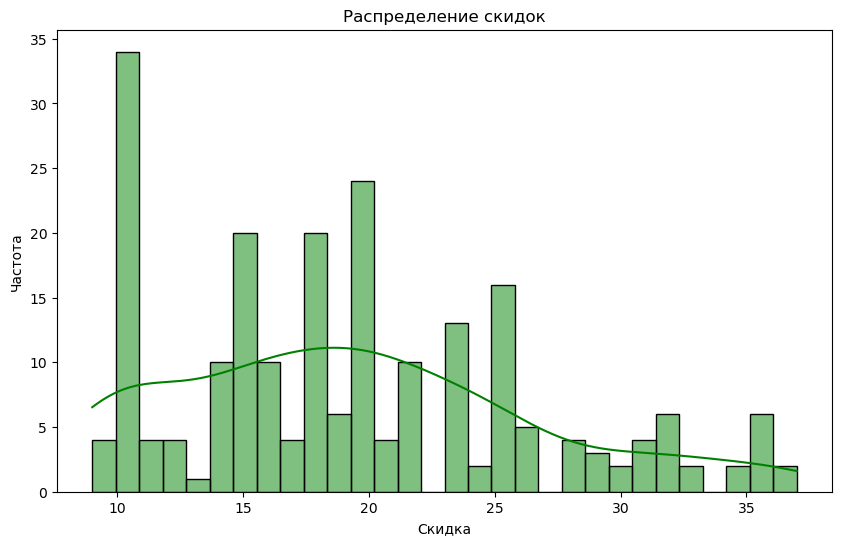

In [1254]:
# Распределение скидок
plt.figure(figsize=(10, 6))
sns.histplot(df['discount'], bins=30, kde=True, color='green')
plt.title('Распределение скидок')
plt.xlabel('Скидка')
plt.ylabel('Частота')
plt.show()

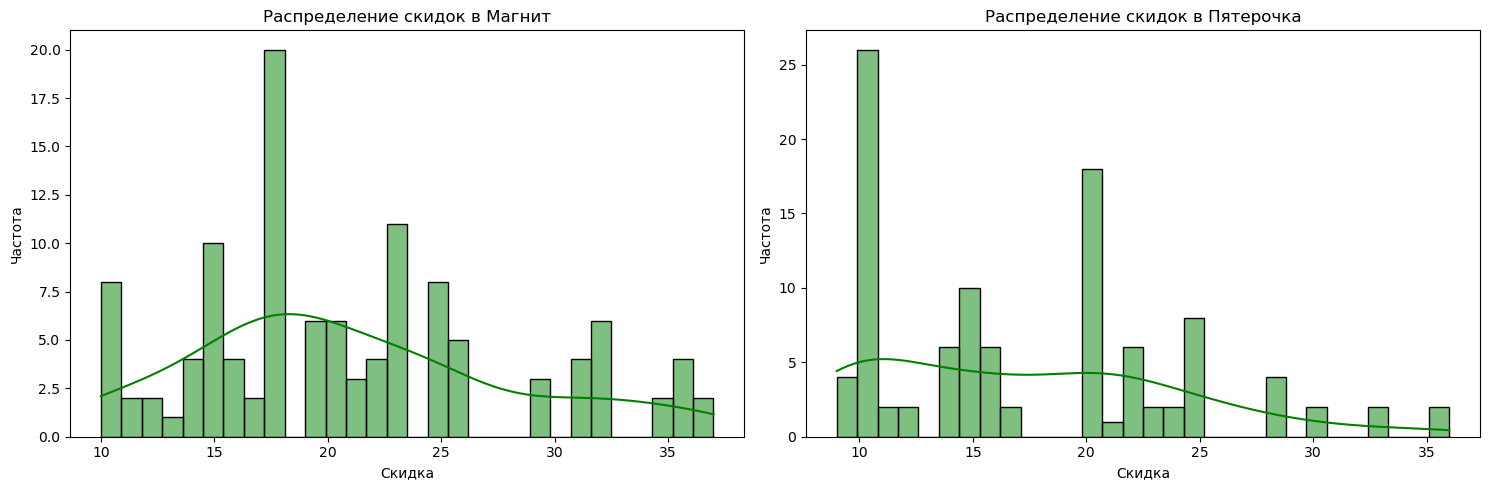

In [1256]:
# Распределение скидок по магазинам
stores = df['store'].unique()
n_stores = len(stores)

n_rows = (n_stores + 1) // 2 
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() 

for i, store in enumerate(stores):
    df_store = df.filter(pl.col('store') == store)
    sns.histplot(df_store['discount'], bins=30, kde=True, ax=axes[i], color='green')
    axes[i].set_title(f'Распределение скидок в {store}')
    axes[i].set_xlabel('Скидка')
    axes[i].set_ylabel('Частота')

for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Динамика средних цен по дням

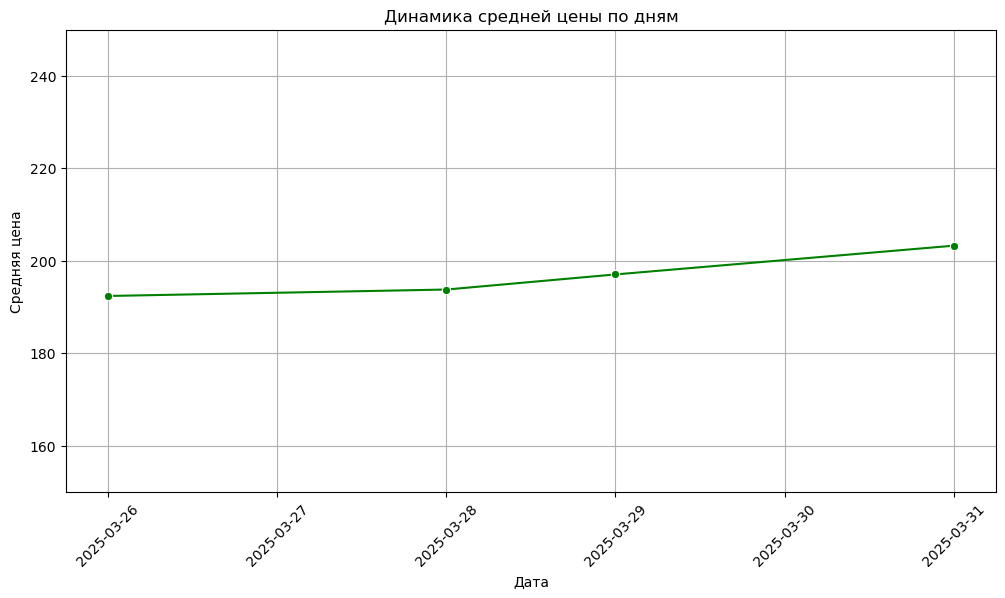

In [1258]:
# Вычисляем среднюю цену по дням
daily_avg_price = (
    df
    .to_pandas()
    .groupby('date_added')
    ['price'].mean()
    .reset_index()
)

# График изменения средней цены по дням
plt.figure(figsize=(12, 6))
plt.ylim(150, 250)
sns.lineplot(x='date_added', y='price', data=daily_avg_price, marker='o', color='green')
plt.title('Динамика средней цены по дням')
plt.xlabel('Дата')
plt.ylabel('Средняя цена')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

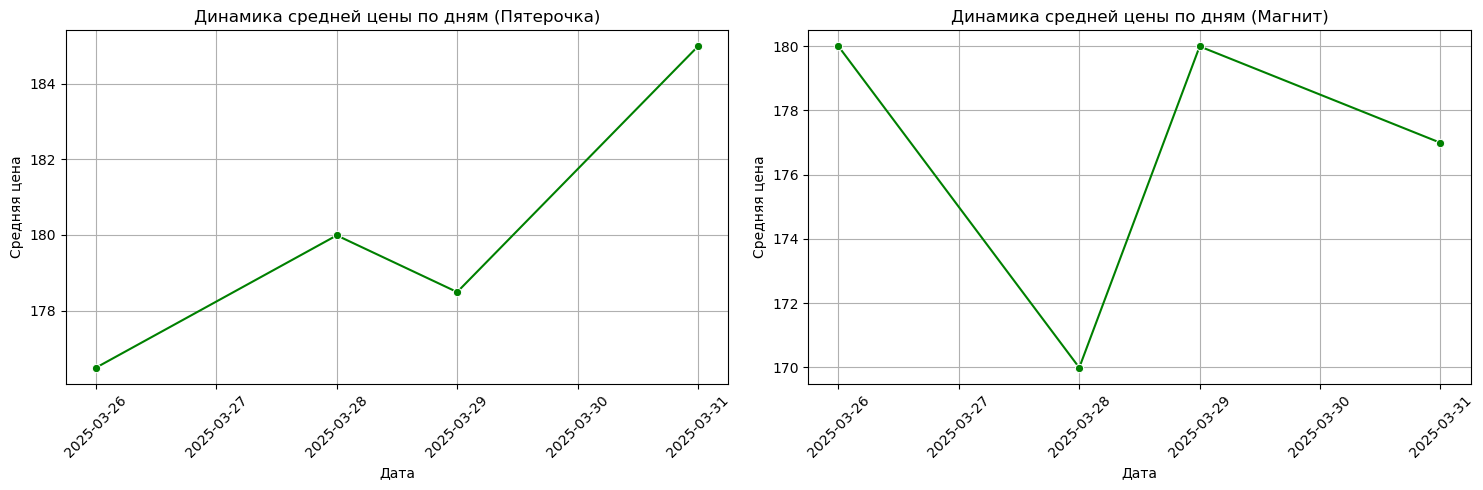

In [1262]:
# Динамика средних цен по дням по магазинам
stores = df['store'].unique()
n_stores = len(stores)

n_rows = (n_stores + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  

for i, store in enumerate(stores):
    df_store = df.filter(pl.col('store') == store)
    daily_avg_price = (
        df_store
        .to_pandas()
        .groupby('date_added')
        ['price'].median()
        .reset_index()
    )
    sns.lineplot(x='date_added', y='price', data=daily_avg_price, marker='o', color='green', ax=axes[i])
    axes[i].set_title(f'Динамика средней цены по дням ({store})')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Средняя цена')
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Матрица корреляции для числовых признаков

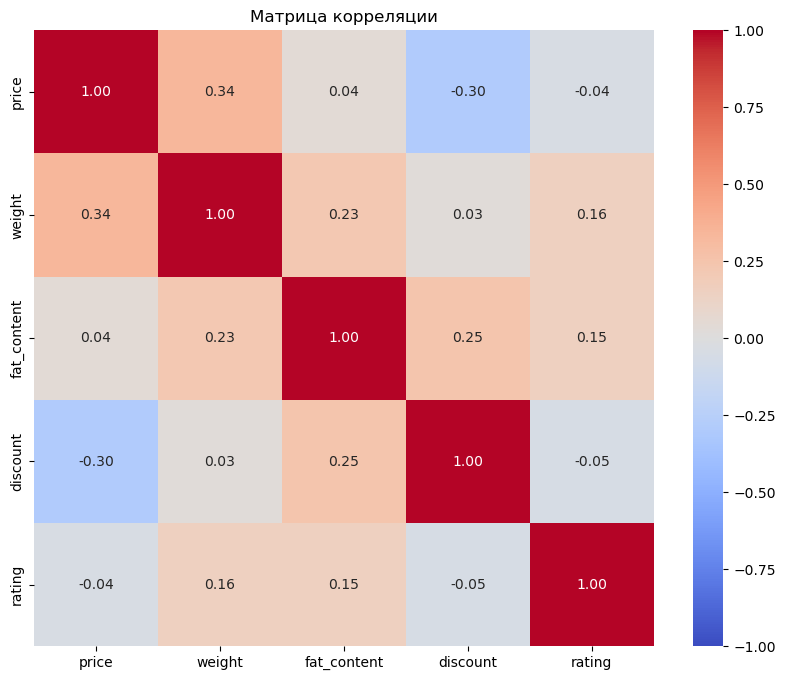

In [1278]:
df_pandas = df.to_pandas()

numeric_columns = df_pandas.select_dtypes(include=['number']).columns

df_numeric = df_pandas[numeric_columns]

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции')
plt.show()


## Доработки

1. Хорошей мыслью является смэтчить наименования продуктов из разных магазинов. Целиком наименования не будут совпадать из-за наличия в названиях сыров в Пятерочке дополнительной информации типа "БЗМЖ". Поэтому необходимо подобрать алгоритм для мэтчинга, возможно по подстроке, возможно по совпадению полей `weight`, `is_sliced`, `fat_content`. Это позволит в дальнейшем находить наиболее выгодное предложение из магазинов.
2. Бренд может некорректно записываться. Сейчас действует правило: бренд - это идущие подряд слова в наименовании (кроме первого), начинающиеся с заглавной буквы.

In [1280]:
# Пример строк
str1 = "Сыр Белебеевский Классический полутвердый 45% БЗМЖ 190г"
str2 = "Сыр Белебеевский 45% 190г"
str3 = "Сыр Белебеевский 50% 200г"

def normalize(s):
    return ' '.join(s.lower().split())

def compare_strings(str1, str2, threshold=0.6):
    similarity = fuzz.ratio(normalize(str1), normalize(str2)) / 100
    return similarity >= threshold

# Сравнение
print(compare_strings(str1, str2)) 
print(compare_strings(str1, str3)) 

True
False


Попробуем применить rapidfuzz.ratio для определения одинаковых товаров

In [1282]:
df_copy = df_pandas.copy()

In [1284]:
df_copy['name_normalized'] = df_copy['name'].str.lower()

# Функция для сравнения строк с использованием rapidfuzz
def is_similar(str1, str2, threshold=60):
    return fuzz.ratio(str1, str2) >= threshold

# Группировка товаров по схожести наименований, fat_content и weight
def group_similar_products(df, threshold=80):
    groups = []  # Список для хранения групп
    group_ids = {}  # Словарь для хранения id групп
    next_id = 1  # Счетчик для уникальных id

    for i, row in df.iterrows():
        matched_group = None
        for group in groups:
            # Проверяем совпадение fat_content и weight
            if (row['fat_content'] == group['fat_content'] and
                row['weight'] == group['weight'] and
                row['brand'] == group['brand'] and
                is_similar(row['name_normalized'], group['name_normalized'], threshold)):
                matched_group = group
                break

        if matched_group:
            group_ids[i] = matched_group['id']  # Присваиваем id существующей группы
        else:
            # Создаем новую группу
            new_group = {
                'id': next_id, 
                'name_normalized': row['name_normalized'],
                'fat_content': row['fat_content'], 
                'brand': row['brand'],
                'weight': row['weight']
            }
            groups.append(new_group)
            group_ids[i] = next_id
            next_id += 1

    df['product_id'] = df.index.map(group_ids)
    return df

df_with_ids = group_similar_products(df_copy)
df_with_ids.head()

,name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,discount,rating,name_normalized,product_id
0,Сыр Belster Parmesan нарезка 40% БЗМЖ 135г,219.99,2025-03-26,Пятерочка,Belster Parmesan,135.0,г,40.0,True,True,NaN,NaN,сыр belster parmesan нарезка 40% бзмж 135г,1
1,Сыр Брест-Литовск Монастырский 45% БЗМЖ 200г,179.99,2025-03-26,Пятерочка,Брест-Литовск Монастырский,200.0,г,45.0,None,True,NaN,NaN,сыр брест-литовск монастырский 45% бзмж 200г,2
2,Сыр Сырцееды копченый со вкусом томата 30% БЗМ...,49.99,2025-03-26,Пятерочка,Сырцееды,23.0,г,30.0,None,True,NaN,NaN,сыр сырцееды копченый со вкусом томата 30% бзм...,3
3,Сыр творожный Violette сливочный 70% БЗМЖ 180г,184.99,2025-03-26,Пятерочка,Violette,180.0,г,70.0,None,True,NaN,NaN,сыр творожный violette сливочный 70% бзмж 180г,4
4,Сыр Свежий Ряд Чечил спагетти копченый БЗМЖ 100г,149.99,2025-03-26,Пятерочка,Свежий Ряд Чечил,100.0,г,NaN,None,True,NaN,NaN,сыр свежий ряд чечил спагетти копченый бзмж 100г,5


In [809]:
df_with_ids[df_with_ids['product_id']==21]

,name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,discount,rating,name_normalized,product_id
21,Сыр Viola Бутербродный полутвердый нарезка 45%...,169.99,2025-03-26,Пятерочка,Viola Бутербродный,120.0,г,45.0,True,True,NaN,NaN,сыр viola бутербродный полутвердый нарезка 45%...,21
48,Сыр Viola Бутербродный нарезка 45% 120г,149.99,2025-03-26,Магнит,Viola Бутербродный,120.0,г,45.0,True,None,NaN,NaN,сыр viola бутербродный нарезка 45% 120г,21
259,Сыр Viola Бутербродный полутвердый нарезка 45%...,157.99,2025-03-28,Пятерочка,Viola Бутербродный,120.0,г,45.0,True,True,NaN,NaN,сыр viola бутербродный полутвердый нарезка 45%...,21
330,Сыр Viola Бутербродный нарезка 45% 120г,149.99,2025-03-28,Магнит,Viola Бутербродный,120.0,г,45.0,True,None,NaN,NaN,сыр viola бутербродный нарезка 45% 120г,21
583,Сыр Viola Бутербродный полутвердый нарезка 45%...,157.99,2025-03-29,Пятерочка,Viola Бутербродный,120.0,г,45.0,True,True,16.0,4.9,сыр viola бутербродный полутвердый нарезка 45%...,21


In [863]:
df_with_ids[df_with_ids['product_id']==47]

,name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,discount,rating,name_normalized,product_id
47,Сыр Брест-Литовск Российский 50% 200г,239.99,2025-03-26,Магнит,Брест-Литовск Российский,200.0,г,50.0,None,None,NaN,NaN,сыр брест-литовск российский 50% 200г,47
122,Сыр полутвердый Брест-Литовск Российский 50% Б...,175.99,2025-03-26,Пятерочка,Брест-Литовск Российский,200.0,г,50.0,None,True,NaN,NaN,сыр полутвердый брест-литовск российский 50% б...,47
220,Сыр полутвердый Брест-Литовск Российский 50% Б...,175.99,2025-03-28,Пятерочка,Брест-Литовск Российский,200.0,г,50.0,None,True,NaN,NaN,сыр полутвердый брест-литовск российский 50% б...,47
356,Сыр Брест-Литовск Российский 50% 200г,239.99,2025-03-28,Магнит,Брест-Литовск Российский,200.0,г,50.0,None,None,NaN,NaN,сыр брест-литовск российский 50% 200г,47
481,Сыр полутвердый Брест-Литовск Российский 50% Б...,175.99,2025-03-29,Пятерочка,Брест-Литовск Российский,200.0,г,50.0,None,True,20.0,4.92,сыр полутвердый брест-литовск российский 50% б...,47
529,Сыр Брест-Литовск Российский 50% 200г,239.99,2025-03-29,Магнит,Брест-Литовск Российский,200.0,г,50.0,None,None,NaN,4.70,сыр брест-литовск российский 50% 200г,47


In [897]:
df_with_ids[df_with_ids['product_id']==64]

,name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,discount,rating,name_normalized,product_id
66,Сыр Экомилк творожный 60% 350г,329.99,2025-03-26,Магнит,Экомилк,350.0,г,60.0,None,None,NaN,NaN,сыр экомилк творожный 60% 350г,64
132,Сыр Экомилк творожный 60% 350г,299.99,2025-03-26,Пятерочка,Экомилк,350.0,г,60.0,None,None,NaN,NaN,сыр экомилк творожный 60% 350г,64
268,Сыр Экомилк творожный 60% 350г,299.99,2025-03-28,Пятерочка,Экомилк,350.0,г,60.0,None,None,NaN,NaN,сыр экомилк творожный 60% 350г,64
332,Сыр Экомилк творожный 60% 350г,329.99,2025-03-28,Магнит,Экомилк,350.0,г,60.0,None,None,NaN,NaN,сыр экомилк творожный 60% 350г,64
500,Сыр Экомилк творожный 60% 350г,329.99,2025-03-29,Магнит,Экомилк,350.0,г,60.0,None,None,NaN,4.4,сыр экомилк творожный 60% 350г,64


In [905]:
df_with_ids[df_with_ids['product_id']==68]

,name,price,date_added,store,brand,weight,unit,fat_content,is_sliced,is_bzmj,discount,rating,name_normalized,product_id
70,Сыр Брест-Литовск Классический 45% нарезка 150г,179.99,2025-03-26,Магнит,Брест-Литовск Классический,150.0,г,45.0,True,None,NaN,NaN,сыр брест-литовск классический 45% нарезка 150г,68
180,Сыр Брест-Литовск Классический нарезка 45% БЗМ...,169.99,2025-03-26,Пятерочка,Брест-Литовск Классический,150.0,г,45.0,True,True,NaN,NaN,сыр брест-литовск классический нарезка 45% бзм...,68
314,Сыр Брест-Литовск Классический нарезка 45% БЗМ...,179.99,2025-03-28,Пятерочка,Брест-Литовск Классический,150.0,г,45.0,True,True,NaN,NaN,сыр брест-литовск классический нарезка 45% бзм...,68
369,Сыр Брест-Литовск Классический 45% нарезка 150г,179.99,2025-03-28,Магнит,Брест-Литовск Классический,150.0,г,45.0,True,None,NaN,NaN,сыр брест-литовск классический 45% нарезка 150г,68
491,Сыр Брест-Литовск Классический нарезка 45% БЗМ...,179.99,2025-03-29,Пятерочка,Брест-Литовск Классический,150.0,г,45.0,True,True,10.0,4.92,сыр брест-литовск классический нарезка 45% бзм...,68
557,Сыр Брест-Литовск Классический 45% нарезка 150г,179.99,2025-03-29,Магнит,Брест-Литовск Классический,150.0,г,45.0,True,None,18.0,4.70,сыр брест-литовск классический 45% нарезка 150г,68


Пример смэтченного. На деле их больше должно быть.

## Идея для разметки

Можно попробовать реализовать **экспертную разметку брендов**. Это может быть впоследствии использовано для улучшения качества мэтчинга, потому что оценка смэтченных продуктов показала, что имеет место несовпадение между магазинами заполненного бренда.
Напомню, бренд заполняется как последовательность идущих подряд слов (кроме первого), начинающихся с заглавной буквы. 

Пример одинакового продукта, по-разному записанный в магазинах: 
1) "Сыр Белебеевский Российский 40% БЗМЖ 200г" - Бренд: Белебеевский Российский
2) "Сыр Белебеевский 40% 200г" - Бренд: Белебеевский

Корректный вариант бренда в примере - Белебеевский. Ввиду различий в наименовании одинаковый продукт между магазинами не мэтчится.